Epoch 1/200
574/574 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 25631364.0000 - mae: 3404.7708 - val_loss: 2857830.5000 - val_mae: 1103.0338
Epoch 2/200
574/574 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2879836.5000 - mae: 1023.3635 - val_loss: 2149818.2500 - val_mae: 865.5382
Epoch 3/200
574/574 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 2172129.0000 - mae: 846.6628 - val_loss: 2068862.5000 - val_mae: 846.8630
Epoch 4/200
574/574 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 2146521.0000 - mae: 843.4932 - val_loss: 2102153.5000 - val_mae: 846.8298
Epoch 5/200
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2319636.5000 - mae: 839.8019 - val_loss: 2018223.1250 - val_mae: 843.2472
Epoch 6/200
574/574 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2337532.0000 - mae: 830.1685 - val_loss: 1972318.6250 - val_mae: 832.6735
Epoch 7/200
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2173593.7500 - mae: 828.6354 - val_loss: 1918820.7500 - val_mae: 809.9960
Epoch 8/200
574/574 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/st

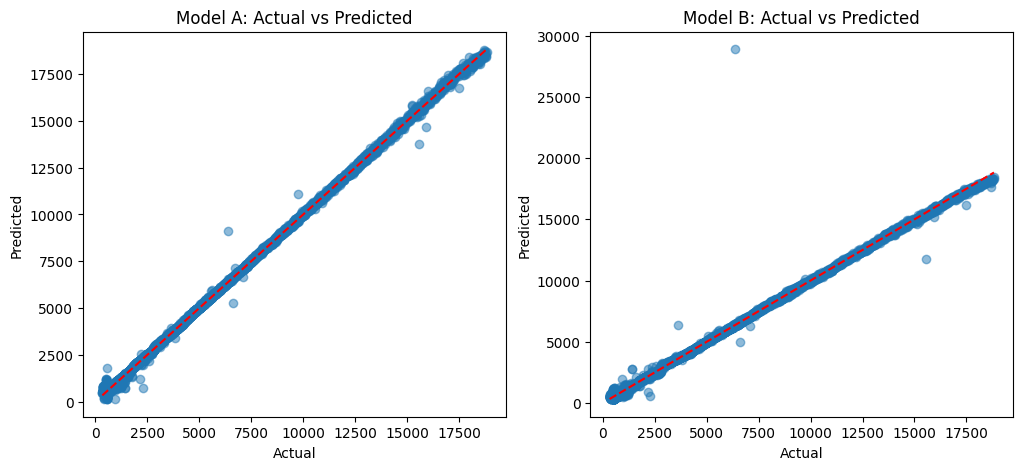

In [3]:
# ========================
# Neural Networks on Colab
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# -------------------- 1. Load data --------------------
df = pd.read_csv("/content/diamonds.csv")  # Colab path after upload
target = 'price'
features = df.drop(columns=[target]).select_dtypes(include=[np.number]).columns
X = df[features].values
y = df[target].values

# -------------------- 2. Split and scale --------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -------------------- 3. Model A: Simple MLP --------------------
def build_mlp_baseline(input_dim):
    return models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

model_a = build_mlp_baseline(X_train_scaled.shape[1])
model_a.compile(optimizer=optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_a = model_a.fit(X_train_scaled, y_train, validation_split=0.15, epochs=200, batch_size=64, callbacks=[es], verbose=1)
y_pred_a = model_a.predict(X_test_scaled).ravel()

# -------------------- 4. Model B: Advanced MLP --------------------
def build_mlp_advanced(input_dim):
    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(256, activation='relu')(inp)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1)(x)
    return models.Model(inputs=inp, outputs=out)

model_b = build_mlp_advanced(X_train_scaled.shape[1])
model_b.compile(optimizer=optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
es2 = callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True)
rlrop = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6)
history_b = model_b.fit(X_train_scaled, y_train, validation_split=0.15, epochs=300, batch_size=64, callbacks=[es2, rlrop], verbose=1)
y_pred_b = model_b.predict(X_test_scaled).ravel()

# -------------------- 5. Metrics --------------------
def print_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

print_metrics('Model A (Simple MLP)', y_test, y_pred_a)
print_metrics('Model B (Advanced MLP)', y_test, y_pred_b)

# -------------------- 6. Plots --------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_a, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Model A: Actual vs Predicted'); plt.xlabel('Actual'); plt.ylabel('Predicted')

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_b, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Model B: Actual vs Predicted'); plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.show()